# 异常检测
这部分，将实现一个异常检测算法来检测服务器计算机中的异常行为。数据集中的特征是测量每个服务器的响应速度(mb/s)和延迟(ms)。在服务器运行时，收集到了的无标签的m=307个样本。其中绝大多数样本是正常的，但还是有一小部分的样本是异常的。将使用高斯分布模型来检测数据集中的异常样本。

In [28]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

## 加载数据

In [35]:
mat = loadmat('date/ex8data1.mat')
print(mat.keys())
# dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])
X = mat['X']
Xval, yval = mat['Xval'], mat['yval']
X.shape, Xval.shape, yval.shape
# ((307, 2), (307, 2), (307, 1))

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])


((307, 2), (307, 2), (307, 1))

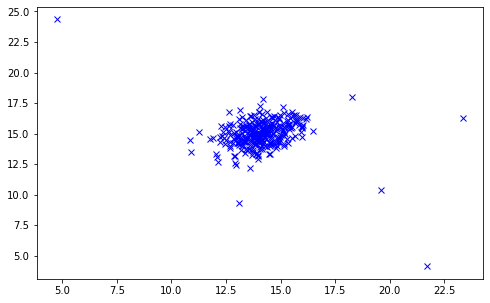

In [36]:
def plot_data():
    plt.figure(figsize=(8,5))
    plt.plot(X[:,0], X[:,1], 'bx')
    # plt.scatter(Xval[:,0], Xval[:,1], c=yval.flatten(), marker='x', cmap='rainbow')
    
plot_data()


这是一个非常紧密的聚类，几个值远离了聚类。 在这个简单的例子中，这些可以被认为是异常的。

## 计算高斯分布
要执行异常检测，首先需要将模型拟合数据的分布。
给定训练集$x_{(1)},...,x_{(m)}$, 我们想要对每个特征$x_i$做高斯分布估计。对于每个特征，$i=1...n$，我们需要找到参数 $u_i,δ^2_i$来拟合数据。$$\mu_j=\frac{1}{m}\sum\limits_{i=1}^{m}x_j^{(i)},\sigma_j^2=\frac{1}{m}\sum\limits_{i=1}^m(x_j^{(i)}-\mu_j)^2$$
$$p(x)=\prod\limits_{j=1}^np(x_j;\mu_j,\sigma_j^2)=\prod\limits_{j=1}^1\frac{1}{\sqrt{2\pi}\sigma_j}exp(-\frac{(x_j-\mu_j)^2}{2\sigma_j^2})$$

In [38]:
def gaussian(X, mu, sigma2):
    '''
    mu, sigma2参数已经决定了一个高斯分布模型
    因为原始模型就是多元高斯模型在sigma2上是对角矩阵而已，所以如下：
    If Sigma2 is a matrix, it is treated as the covariance matrix. 
    If Sigma2 is a vector, it is treated as the sigma^2 values of the variances
    in each dimension (a diagonal covariance matrix)
    output:
        一个(m, )维向量，包含每个样本的概率值。
    '''
# 下面是不利用矩阵的解法，相当于把每行数据输入进去，不会出现内存错误。
    m, n = X.shape
    if np.ndim(sigma2) == 1:
        sigma2 = np.diag(sigma2)

    norm = 1./(np.power((2*np.pi), n/2)*np.sqrt(np.linalg.det(sigma2)))
    exp = np.zeros((m,1))
    for row in range(m):
        xrow = X[row]
        exp[row] = np.exp(-0.5*((xrow-mu).T).dot(np.linalg.inv(sigma2)).dot(xrow-mu))
    return norm*exp

## 根据数据估计出模型的参数

In [39]:
def getGaussianParams(X, useMultivariate):
    """
    The input X is the dataset with each n-dimensional data point in one row
    The output is an n-dimensional vector mu, the mean of the data set 
    the variances sigma^2, an n x 1 vector 或者是(n,n)矩阵，if你使用了多元高斯函数
    作业这里求样本方差除的是 m 而不是 m - 1，实际上效果差不了多少。
    """
    mu = X.mean(axis=0)
    if useMultivariate:    
        sigma2 = ((X-mu).T @ (X-mu)) / len(X)
    else:
        sigma2 = X.var(axis=0, ddof=0)  # 样本方差
    
    return mu, sigma2



## 根据估计出的参数，画出高斯分布的等高线

In [40]:
def plotContours(mu, sigma2):
    """
    画出高斯概率分布的图，在三维中是一个上凸的曲面。投影到平面上则是一圈圈的等高线。
    """
    delta = .3  # 注意delta不能太小！！！否则会生成太多的数据，导致矩阵相乘会出现内存错误。
    x = np.arange(0,30,delta)
    y = np.arange(0,30,delta)
    
    # 这部分要转化为X形式的坐标矩阵，也就是一列是横坐标，一列是纵坐标，
    # 然后才能传入gaussian中求解得到每个点的概率值
    xx, yy = np.meshgrid(x, y)
    points = np.c_[xx.ravel(), yy.ravel()]  # 按列合并，一列横坐标，一列纵坐标
    z = gaussian(points, mu, sigma2)
    z = z.reshape(xx.shape)  # 这步骤不能忘
    
    cont_levels = [10**h for h in range(-20,0,3)]
    plt.contour(xx, yy, z, cont_levels)  # 这个levels是作业里面给的参考,或者通过求解的概率推出来。

    plt.title('Gaussian Contours',fontsize=16)



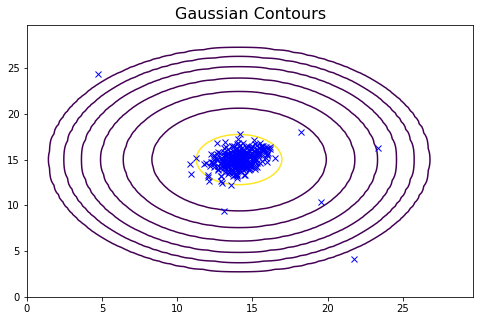

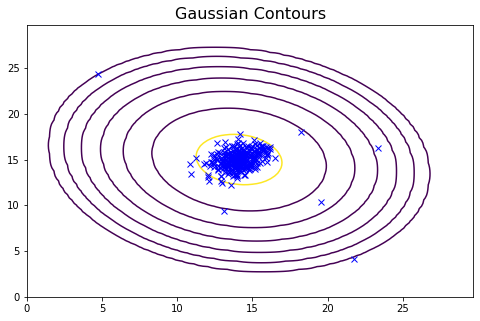

In [41]:
# First contours without using multivariate gaussian:
plot_data()
useMV = False
plotContours(*getGaussianParams(X, useMV))

# Then contours with multivariate gaussian:
plot_data()
useMV = True
# *表示解元组
plotContours(*getGaussianParams(X, useMV))


## Selecting the threshold, ε
确定哪些例子是异常的一种方法是通过一组交叉验证集，选择一个好的阈值 ε 。

在这部分的练习中,您将实现一个算法使用交叉验证集的F1分数来选择合理的阈值 ε 。
![](https://imgconvert.csdnimg.cn/aHR0cHM6Ly91cGxvYWQtaW1hZ2VzLmppYW5zaHUuaW8vdXBsb2FkX2ltYWdlcy8xMTAyMzI2Mi03MWI2YmI2N2M0OWFjM2M5LnBuZw)
tp means true positives：是异常值，并且我们的模型预测成异常值了，即真的异常值。

fp means false positives：是正常值，但模型把它预测成异常值，即假的异常值。

fn means false negatives：是异常值，但是模型把它预测成正常值，即假的正常值。

precision 表示你预测为positive的样本中有多少是真的positive的样本。

recall 表示实际有多少positive的样本，而你成功预测出多少positive的样本。

In [43]:
def selectThreshold(yval, pval):
    def computeF1(yval, pval):
        m = len(yval)
        tp = float(len([i for i in range(m) if pval[i] and yval[i]]))
        fp = float(len([i for i in range(m) if pval[i] and not yval[i]]))
        fn = float(len([i for i in range(m) if not pval[i] and yval[i]]))
        prec = tp/(tp+fp) if (tp+fp) else 0
        rec = tp/(tp+fn) if (tp+fn) else 0
        F1 = 2*prec*rec/(prec+rec) if (prec+rec) else 0
        return F1
   
    epsilons = np.linspace(min(pval), max(pval), 1000)
    bestF1, bestEpsilon = 0, 0
    for e in epsilons:
        pval_ = pval < e
        thisF1 = computeF1(yval, pval_)
        if thisF1 > bestF1:
            bestF1 = thisF1
            bestEpsilon = e

    return bestF1, bestEpsilon


In [44]:
mu, sigma2 = getGaussianParams(X, useMultivariate=False)
pval = gaussian(Xval, mu, sigma2)
bestF1, bestEpsilon = selectThreshold(yval, pval)  
# (0.8750000000000001, 8.999852631901397e-05)


In [45]:
y = gaussian(X, mu, sigma2)  # X的概率
xx = np.array([X[i] for i in range(len(y)) if y[i] < bestEpsilon])
xx  # 离群点


array([[13.07931049,  9.34787812],
       [21.72713402,  4.12623222],
       [19.58257277, 10.411619  ],
       [23.33986753, 16.29887355],
       [18.26118844, 17.978309  ],
       [ 4.75261282, 24.35040725]])

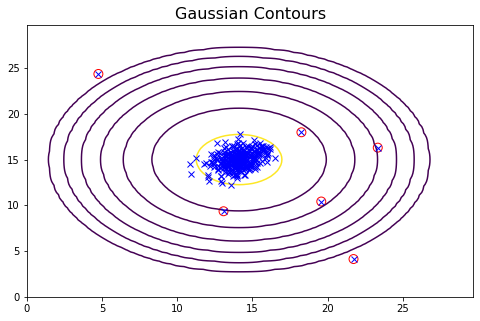

In [47]:
plot_data()
plotContours(mu, sigma2)
plt.scatter(xx[:,0], xx[:,1], s=80, facecolors='none', edgecolors='r')
